## 实验1，调整gamma，观察

### 环境及智能体

- 环境： MinorityGame_1， 少数派游戏，101人博弈，无穷博弈，创建环境时可自定义环境承载量，本实验中固定为50
- 智能体：QLearningAgent，创建智能体时支持自定义学习率、折扣因子以及探索系数，本实验中固定学习率和探索系数，观察不同折扣因子对玩家决策及收益的影响

### 实验结果

101人少数博弈，固定环境承载量为50，学习率为0.1，探索系数为0.1时，选取不同的折扣因子,观察玩家决策和平均收益未发现明显影响。

### 实验内容

#### 实验准备

In [115]:
# MG环境
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
import copy
import math, random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np


# %matplotlib inline

class MinorityGame_1(gym.Env):
    '''
    Minority Game, we have some agent, every agent can choose 1 or 0 every day.
    In midnight, all of the day to make a few choices of the agent to get +1 reward.
    '''

    def __init__(self, env_max=50):
        '''
        环境初始化:
        玩家数固定101;
        env_max 环境承载量，选择1能获取收益的最大人数，默认为50;
        action_space 动作空间，大小为2，玩家只能选择0或1;
        observation_space 观测空间，这个环境使用2，玩家立足于上一次博弈的状态;
        '''
        self.env_max = env_max
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(2)
        self.seed()


    def seed(self, seed=None):
        '''
        设置seed
        '''
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action_101):
        '''
        每一步博弈：
        1. 检查输入是否合法
        2. 统计选择1的人数allpick，allpick不超过env_max则1获胜，否则0获胜
        3. 返回S(玩家本回合动作), R(所有玩家的奖励列表), done(False，无尽博弈)
        '''
        assert len(action_101) == 101
        assert all(map(lambda x:self.action_space.contains(x), action_101))
        allpick = sum(action_101)
        reward_101 = []
        for action in action_101:
            if action == 1 and allpick <= self.env_max or action == 0 and allpick > self.env_max:
                reward_101.append(1)
            else:
                reward_101.append(0)

        done = True

        return action_101, reward_101, done, {}

    def reset(self):
        '''
        重置环境，每轮第一次博弈给所有玩家一个随机状态
        '''
        # return [0]*101
        return [random.randint(0,1) for _ in range(101)]


In [116]:
# Qlearning智能体
class QLearningAgent:
    '''
    Q-learning智能体实现
    '''

    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.1):
        '''
        Q-learning智能体初始化:
        env 智能体的博弈环境；
        gamma 折扣因子，n步后的奖励为 pow(gamma, n)*Rn, gamma越大表示越重视长期收益。
        learning_rata 学习率，Qlearning 更新过程为:Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)),
                      学习率越大表示越不依赖过去学习的结果
        '''
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        

    def decide(self, state):
        '''
        epsilon-greedy策略，另外Q表所有值相等表示智能体还没有学到任何经验，这时也鼓励探索。
        '''
        if np.random.uniform() > self.epsilon and self.q[state].argmax() != self.q[state].argmin():
            action = self.q[state].argmax()
        else:
            action = 0 if np.random.randint(self.action_n) < 0.5 else 1
        return action
    
    def learn(self, state, action, reward, next_state, done):
        '''
        Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)
        '''
        u = reward + self.gamma * self.q[next_state].max()
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [117]:
def play_qlearning(env, agent_101, episodes,render=False):
    '''
    Qlearning智能体一次游戏
    参数:
    env: 游戏环境
    agent_101：101个智能体列表
    episodes: 最大轮数
    render：是否图形显示
    返回值：
    episode_reward
    '''
    episode_rewards = []
    episode_actions = []
    # 初始化S
    observation_101 = env.reset()
    for _ in range(episodes):
        # 各智能体根据环境选择动作
        action_101 = [agent.decide(observation) for agent, observation in zip(agent_101, observation_101)]
        # 执行动作后得到环境奖励和新状态
        next_observation_101, reward_101, done, _ = env.step(action_101)
        # 为所有智能体更新Q表
        for agent, observation, action, reward, next_observation in zip(agent_101, observation_101, action_101, reward_101, next_observation_101):
            agent.learn(observation, action, reward, next_observation,done)
        # 更新状态
        observation = next_observation
        # 上面是Q-learning完整的一步，下面是数据统计
        # 统计动作
        episode_actions.append(action_101)
        # 统计奖励
        episode_rewards.append(reward_101)
    return episode_rewards, episode_actions

In [118]:
def moving_average(lst, N):
    '''
    计算移动平均
    参数:
    lst: 输入列表
    N: 窗口大小
    返回值:
    res: 移动平均列表
    '''
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(sum(lst[l:r])/(r-l))
    return res

def density(lst):
    '''
    将玩家决策原始数据转换成密度数据
    参数:
    lst: 玩家决策原始数据
    返回值:
    res: 玩家决策密度数据
    例:
    输入: [1,1,2,3]
    输出: [0,2,1,1] + [0]*98
    '''
    from collections import Counter
    res = [0] * 102
    tbl = Counter(lst)
    for i in tbl:
        res[i] = tbl[i]/len(lst)
    return res

### 实验过程

1. 基础测试：gamma = 0.1, learning_rate=0.1, epislon=0,1, 博弈3000次，观察玩家收益和动作

In [119]:
# 创建环境
env = MinorityGame_1(50)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.1) for _ in range(101)]

In [120]:
rewards_0, actions_0 = play_qlearning(env,agent_101,3000)

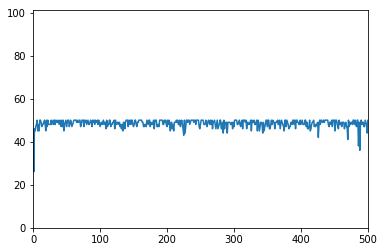

In [121]:
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

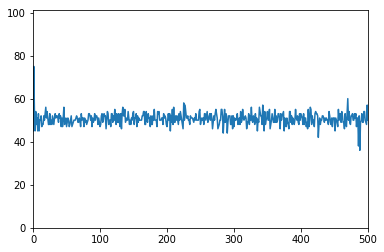

In [122]:
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_0])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

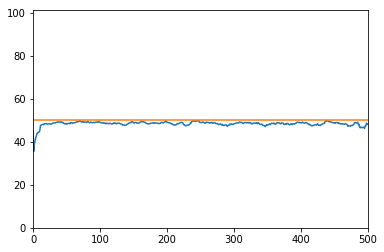

In [123]:
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],10))
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

2. 调整gamma，观测对结果的影响

玩家总收益


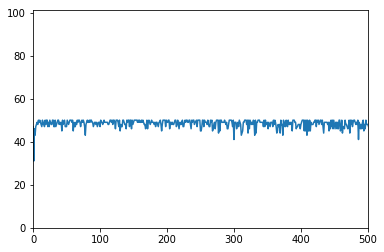

选择1的人数


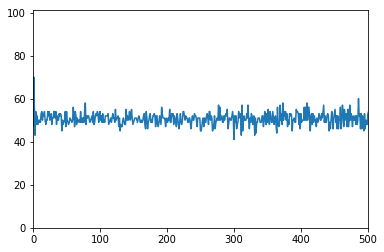

玩家总收益10轮移动平均


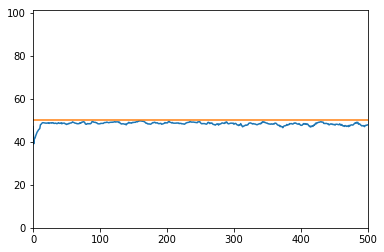

In [124]:
# 创建环境
env = MinorityGame_1(50)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.05,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1a, actions_1a = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1a])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10))
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


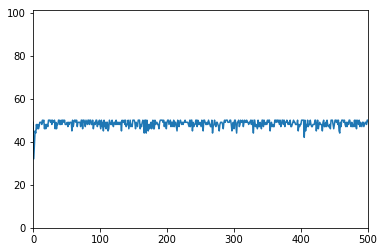

选择1的人数


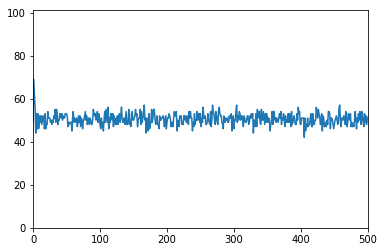

玩家总收益10轮移动平均


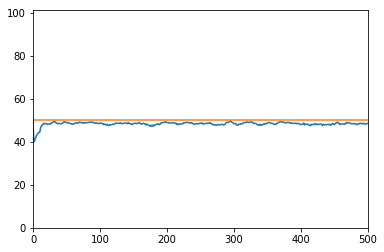

In [125]:
# 创建环境
env = MinorityGame_1(50)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.3,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1b, actions_1b = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1b])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10))
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


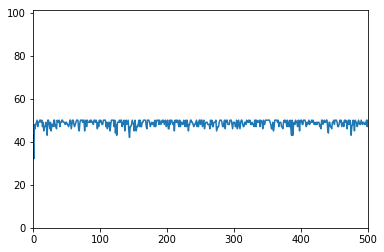

选择1的人数


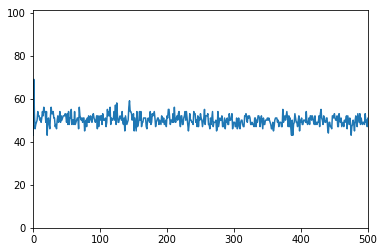

玩家总收益10轮移动平均


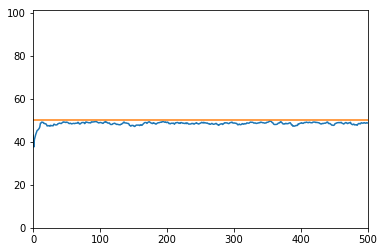

In [126]:
# 创建环境
env = MinorityGame_1(50)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.6,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1c, actions_1c = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1c])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10))
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


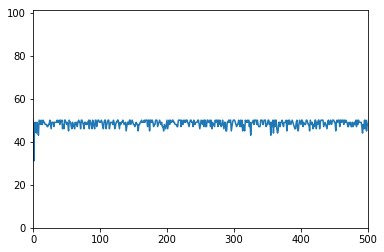

选择1的人数


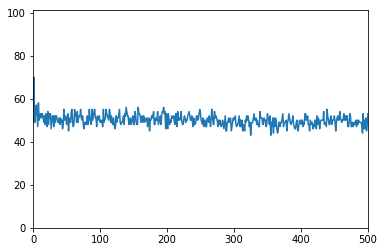

玩家总收益10轮移动平均


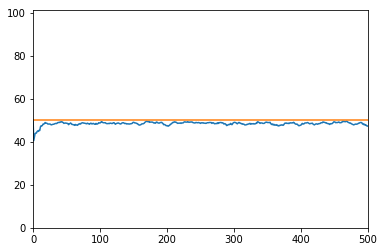

In [127]:
# 创建环境
env = MinorityGame_1(50)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1d, actions_1d = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1d])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10))
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

不同gamma对平均收益的影响


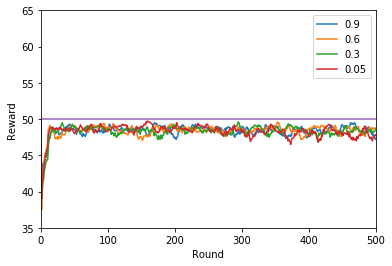

In [128]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同gamma对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10),label ='0.3')
# plt.plot(moving_average([sum(reward) for reward in rewards_0],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10),label ='0.05')
plt.plot([50]*3000)
plt.ylim(35,65)
plt.xlim(0,500)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


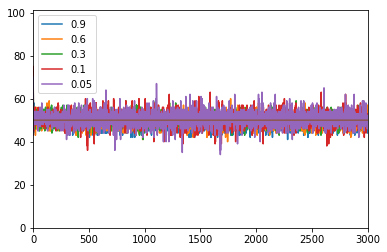

In [129]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")

plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_1d],1),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in actions_1c],1),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in actions_1b],1),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in actions_0],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_1a],1),label ='0.05')
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


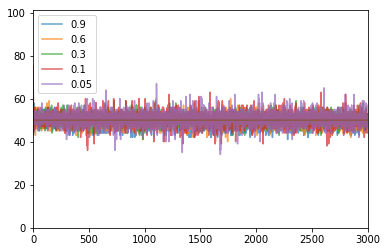

In [130]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")

plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_1d],1),label ='0.9', alpha = .7)
plt.plot(moving_average([sum(reward) for reward in actions_1c],1),label ='0.6', alpha = .7)
plt.plot(moving_average([sum(reward) for reward in actions_1b],1),label ='0.3', alpha = .7)
plt.plot(moving_average([sum(reward) for reward in actions_0],1),label ='0.1', alpha = .7)
plt.plot(moving_average([sum(reward) for reward in actions_1a],1),label ='0.05', alpha = .7)
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


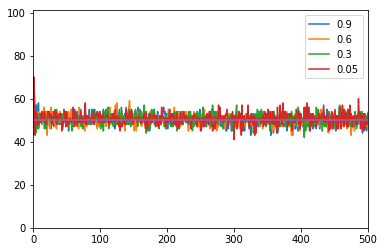

In [131]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")

plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_1d[0:1000]],1),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in actions_1c[0:1000]],1),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in actions_1b[0:1000]],1),label ='0.3')
# plt.plot(moving_average([sum(reward) for reward in actions_0[900:1000]],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_1a[0:1000]],1),label ='0.05')
plt.plot([50]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.legend()
plt.show()

In [132]:
print("平均收益对比")
print("  0.05",sum(sum(r) for r in rewards_1a[400:500])/len(rewards_1a[400:500]))
print("   0.1",sum(sum(r) for r in rewards_0[400:500])/len(rewards_0[400:500]))
print("   0.3",sum(sum(r) for r in rewards_1b[400:500])/len(rewards_1b[400:500]))
print("   0.6",sum(sum(r) for r in rewards_1c[400:500])/len(rewards_1c[400:500]))
print("   0.9",sum(sum(r) for r in rewards_1d[400:500])/len(rewards_1d[400:500]))

平均收益对比
  0.05 48.01
   0.1 48.13
   0.3 48.26
   0.6 48.57
   0.9 48.52


In [133]:
len(rewards_0)

3000

不同gamma对玩家决策的影响


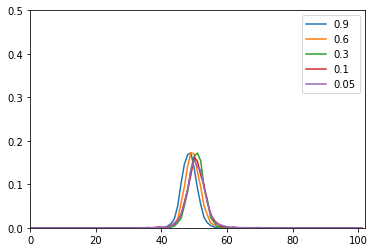

In [134]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.plot(density([sum(reward) for reward in actions_1d]),label ='0.9')
plt.plot(density([sum(reward) for reward in actions_1c]),label ='0.6')
plt.plot(density([sum(reward) for reward in actions_1b]),label ='0.3')
plt.plot(density([sum(reward) for reward in actions_0]),label ='0.1')
plt.plot(density([sum(reward) for reward in actions_1a]),label ='0.05')
plt.xlim(0,102)
plt.ylim(0,0.5)
# plt.axvline(51)
plt.legend()
plt.show()

In [135]:
def variance(lst, N):
    '''
    序列转为方差序列
    参数:
    lst: 输入序列
    N: 计算方差所需元素数
    返回值:
    res: 方差序列
    '''
    import numpy as np
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(np.var(lst[l:r]) if l else 0)
    return res

不同gamma对玩家决策的影响


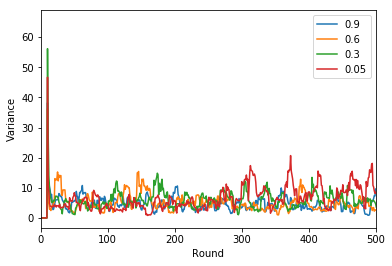

In [136]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Variance")
plt.plot(variance([sum(reward) for reward in actions_1d],10),label ='0.9')
plt.plot(variance([sum(reward) for reward in actions_1c],10),label ='0.6')
plt.plot(variance([sum(reward) for reward in actions_1b],10),label ='0.3')
# plt.plot(variance([sum(reward) for reward in actions_0],10),label ='0.1')
plt.plot(variance([sum(reward) for reward in actions_1a],10),label ='0.05')
plt.xlim(0,500)
# plt.axvline(51)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


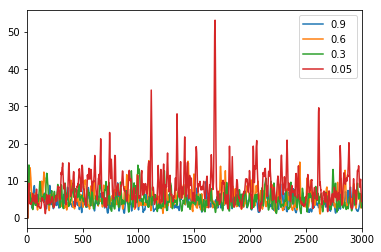

In [137]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.plot(moving_average(variance([sum(reward) for reward in actions_1d],10),10),label ='0.9')
plt.plot(moving_average(variance([sum(reward) for reward in actions_1c],10),10),label ='0.6')
plt.plot(moving_average(variance([sum(reward) for reward in actions_1b],10),10),label ='0.3')
# plt.plot(variance([sum(reward) for reward in actions_0],10),label ='0.1')
plt.plot(moving_average(variance([sum(reward) for reward in actions_1a],10),10),label ='0.05')
plt.xlim(0,3000)
# plt.axvline(51)
plt.legend()
plt.show()

In [138]:
print("平均收益对比")
print("  0.9",sum(sum(r) for r in rewards_1d[100:500])/len(rewards_1d[100:500]))
print("  0.6",sum(sum(r) for r in rewards_1c[100:500])/len(rewards_1c[100:500]))
print("  0.3",sum(sum(r) for r in rewards_1b[100:500])/len(rewards_1b[100:500]))
print("  0.1",sum(sum(r) for r in rewards_0[100:500])/len(rewards_0[100:500]))
print(" 0.05",sum(sum(r) for r in rewards_1a[100:500])/len(rewards_1a[100:500]))
# print("   0.6",sum(sum(r) for r in rewards_1c[400:500])/len(rewards_1c[400:500]))
# print("   0.9",sum(sum(r) for r in rewards_1d[400:500])/len(rewards_1d[400:500]))
# print("random",sum(sum(r) for r in rewards_sp[100:500])/len(rewards_sp[100:500]))

平均收益对比
  0.9 48.505
  0.6 48.4925
  0.3 48.37
  0.1 48.4075
 0.05 48.365


In [139]:
print("决策方差对比")
print("  0.9",np.var([sum(r) for r in actions_1d[100:500]]))
print("  0.6",np.var([sum(r) for r in actions_1c[100:500]]))
print("  0.3",np.var([sum(r) for r in actions_1b[100:500]]))
print("  0.1",np.var([sum(r) for r in actions_0[100:500]]))
print(" 0.05",np.var([sum(r) for r in actions_1a[100:500]]))

决策方差对比
  0.9 5.570943750000001
  0.6 5.9517750000000005
  0.3 6.783599999999999
  0.1 7.428443749999999
 0.05 7.56859375


In [52]:
np.var([sum(r) for r in rewards_1d[100:500]])

2.5059750000000007

[[1.        0.4823123]
 [0.4823123 1.       ]]


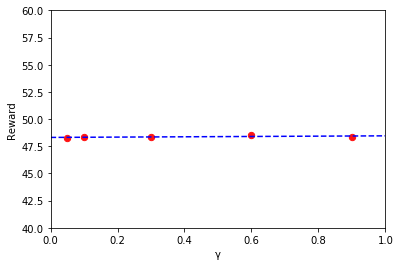

In [114]:
plt.xlabel("γ")
plt.ylabel("Reward")
plt.xlim(0,1)
plt.ylim(40,60)
xData = [0.05, 0.1, 0.3, 0.6, 0.9]
yData = [48.30 , 48.31  , 48.33 , 48.56 , 48.35]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#ff1212", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"b--")

[[ 1.         -0.88409189]
 [-0.88409189  1.        ]]


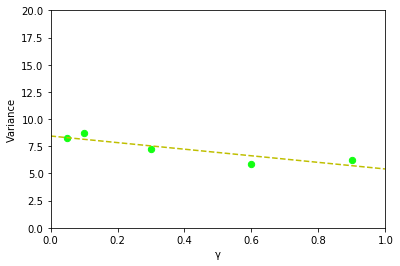

In [113]:
plt.xlabel("γ")
plt.ylabel("Variance")
plt.xlim(0,1)
plt.ylim(0,20)
xData = [0.05, 0.1, 0.3, 0.6, 0.9]
yData = [8.25 , 8.70  , 7.23 , 5.85 , 6.27]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#12ff12", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"y--")

[[ 1.         -0.90213924]
 [-0.90213924  1.        ]]


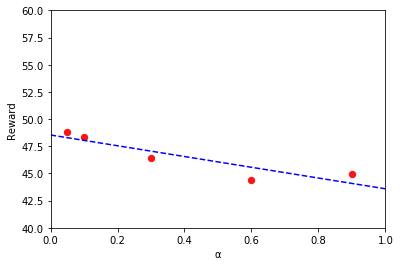

In [112]:
plt.xlabel("α")
plt.ylabel("Reward")
plt.xlim(0,1)
plt.ylim(40,60)
xData = [0.05, 0.1, 0.3, 0.6, 0.9]
yData = [48.80 , 48.39  , 46.43 , 44.43 , 44.98 ]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#ff1212", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"b--")

[[1.        0.8783419]
 [0.8783419 1.       ]]


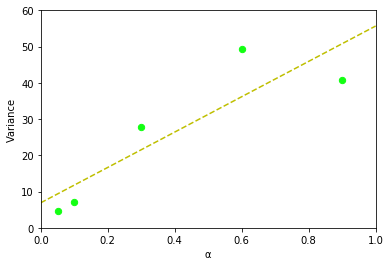

In [111]:
plt.xlabel("α")
plt.ylabel("Variance")
plt.xlim(0,1)
plt.ylim(0,60)
xData = [0.05, 0.1, 0.3, 0.6, 0.9]
yData = [4.53 , 7.19  , 27.92 , 49.33 , 40.68]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#12ff12", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"y--")

[[ 1.         -0.99888691]
 [-0.99888691  1.        ]]


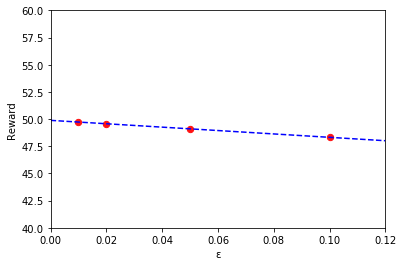

In [109]:
plt.xlabel("ε")
plt.ylabel("Reward")
plt.xlim(0,0.12)
plt.ylim(40,60)
xData = [0.01 , 0.02 , 0.05  , 0.1]
yData = [49.75 , 49.57  , 49.06 , 48.34 ]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#ff1212", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"b--")

[[1.         0.91487813]
 [0.91487813 1.        ]]


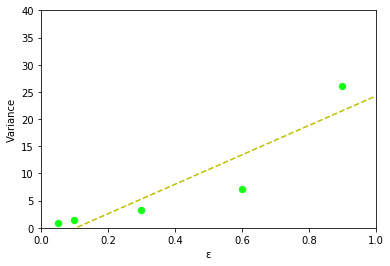

In [108]:
plt.xlabel("ε")
plt.ylabel("Variance")
plt.xlim(0,1)
plt.ylim(0,40)
xData = [0.05, 0.1, 0.3, 0.6, 0.9]
yData = [0.80 , 1.39  , 3.20 , 7.09 , 26.14]
print(np.corrcoef(xData, yData))
plt.scatter(xData, yData, s=40, c="#12ff12", marker='o')
parameter = np.polyfit(xData, yData, 1) # n=1为一次函数，返回函数参数
f = np.poly1d(parameter) # 拼接方程
plt.plot([0,1], f([0,1]),"y--")

In [107]:
xData=[3,2,1]
yData=[1,2,3]
print(np.corrcoef(xData, yData))

[[ 1. -1.]
 [-1.  1.]]
